# AI Revolutionizing Retail: A/B Testing and Optimization Strategies

In this part of our webinar, we will dive into a practical demonstration that showcases the application of A/B testing within the retail sector, powered by AI. We'll be using a Python notebook for our demonstration, making it easy for our viewers to follow along and apply these strategies in their own retail businesses.

## Steps We Will Follow:

1. **Calculate Minimum Detectable Effect (MDE) to Define the Sample Size**
   - We start with a population of 1,000,000 customers. Our objective is to determine the optimal sample size for our A/B test. This is crucial for ensuring that our test results are statistically significant without wasting resources.
   - To achieve this, we will make iterative random splits of our population (5%, 10%, 15%, ..., up to 50%) to forecast the Minimum Detectable Effect (MDE) at each level. The MDE is the smallest effect size that our test is capable of detecting, given our sample size.
   - We will perform this calculation 30 times per sample split to ensure that the average MDE value we obtain is a reliable representation of reality. This iterative approach helps us identify the "best value" sample size – large enough to detect meaningful differences, yet efficient in terms of resource allocation.

2. **Random Split for A/B Testing**
   - Once we've identified the optimal sample size based on our MDE calculations, the next step is to create our A/B test groups. We will randomly split our population into two groups: the control group (Group A) and the experimental group (Group B).
   - This randomization ensures that each group is similar in all respects except for the variable we are testing, which in this case could be anything from a new marketing message to a personalized product recommendation system powered by AI.

3. **Perform a KS Test and a T-Test**

To validate our A/B testing theary, we will employ the Kolmogorov-Smirnov (KS) test. In this scenario, we just want to prove that AB testing makes sense. We will then apply A/B testing as you would in a real use case scenario, in the given example we will use the T-Test.

   - **KS Test:** This non-parametric test allows us to compare the distributions of our two groups and determine if there is a statistical difference between them. It's particularly useful for evaluating the effect of our tested variable across the entire distribution of customer behaviors or outcomes. **Here we want to prove that, since *test* and *control* comes from the same distribution, the p-value will be higher than our significance level (alpha).** In a real case scenario you would skip this KS test and just do the T-Test.

   - **T Test:** This is the "actual" AB test. We chose T-Test since it is usually the one to use in a real case scenario (since you wouldn't know the variance of the population). In this example we do have the population variance since we are generating it synthetically, so a z-test would also be appropriate.

By following these steps, we'll not only understand how to effectively set up and analyze an A/B test but also ensure that our testing process is robust and tailored to detect meaningful insights in the retail context. This hands-on demonstration will equip participants with the knowledge to leverage AI for optimizing their retail strategies through data-driven decision-making.

In [1]:
# Library
import random
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_ind, norm, ks_2samp
from statsmodels.stats.power import TTestIndPower

In [2]:
# Generate a list of 100000 random fake users between 1 and 100000
population = 1000000

# Create the synthetic data for the ab testing example
population_data = [random.randint(1, 100) for _ in range(population)]

# Convert it into
df = pd.DataFrame({'price':population_data})

In [3]:
df.head()

,price
0,34
1,11
2,27
3,40
4,68


(array([ 99910.,  99746.,  99840.,  99795., 100659., 100089.,  99498.,
        100042., 100229., 100192.]),
 array([  1. ,  10.9,  20.8,  30.7,  40.6,  50.5,  60.4,  70.3,  80.2,
         90.1, 100. ]),
 <BarContainer object of 10 artists>)

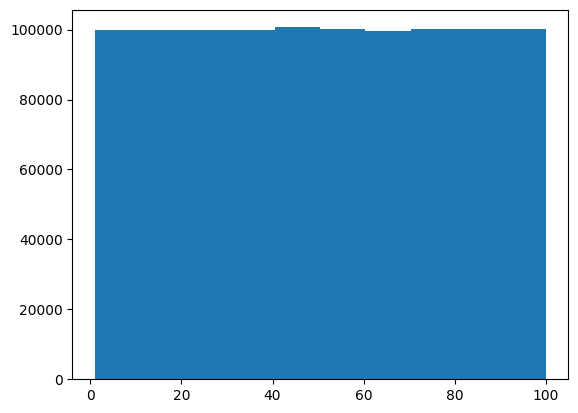

In [4]:
plt.hist(df["price"])

## Understanding Minimum Detectable Effect (MDE) Calculation

In the context of A/B testing, especially in retail or any other domain, determining the Minimum Detectable Effect (MDE) is crucial for designing experiments that are both practical and informative. The MDE tells us the smallest effect size that our test is powered to detect given a specific sample size, significance level (\(\alpha\)), and statistical power (\(1 - \beta\)).

### The Process Explained

1. **Initialization**: We start with a dataset and decide on the fractions of this dataset that we want to test. These fractions range from 5% to 50% in increments of 5%. For each fraction, we aim to calculate the MDE to understand how changing the size of our sample affects our ability to detect meaningful differences between two groups (e.g., a control group and a treatment group).


2. **Simulation Loop**: For each fraction:
   - The dataset is split into a test and control group based on the current fraction size.
   - We perform this split 30 times to mitigate the randomness effect and take the average, ensuring our MDE calculations are robust and reliable.


3. **MDE Calculation**:
   - For each split, we calculate the standard deviation of the test and control groups and then calculate a pooled standard deviation. This pooled standard deviation helps to estimate the common standard deviation between the two groups as if they were a single group.
   - The MDE is calculated using the formula provided below. This formula considers the significance level, the desired power of the test, and the pooled standard deviation to compute the smallest effect size that the test can reliably detect.


4. **Visualization**:
   - After calculating the MDE for each fraction, we plot these values against the sample size. This visual representation helps to understand the relationship between sample size and the detectability of effects, guiding the planning of future A/B tests.


### The Formula for MDE

The MDE is calculated using the following formula:

$$
\text{MDE} = (z_{\alpha/2} + z_{\beta}) \times \text{Pooled Standard Deviation} \times \sqrt{\frac{2}{n}}
$$

Where:
- $z_{\alpha/2}$ is the critical value from the standard normal distribution for a two-tailed test at significance level $\alpha$.
- $z_{\beta}$ is the critical value that corresponds to the desired power (\(1 - \beta\)).
- The pooled standard deviation is an estimate of the common standard deviation of the two groups.
- \(n\) is the sample size of the control group.

### Key Takeaways

- The MDE is a crucial metric in the planning phase of an A/B test. It helps determine the necessary sample size to detect an effect of interest reliably.
- Understanding the relationship between sample size and MDE can help businesses and researchers design more efficient and effective experiments.

This explanation and the accompanying Python script aim to demystify the process of calculating the MDE, making it accessible for individuals planning to conduct A/B tests in various domains.


In [6]:
# Initialize variables
counter = 0  # This will track the fraction of the dataset allocated to the test group
data = {}  # To store results

# Loop to calculate MDE for splits ranging from 5% to 50% of the dataset
while counter <= 0.45:
    counter += 0.05  # Increment the fraction for each iteration
    mde_list = []  # To store MDE values for each iteration
    avg_list = []  # To store average values for the control group

    # Perform 30 simulations for each split to average the MDE
    for i in range(1, 31):
        # Randomly split the dataset into test and control groups based on the current fraction
        test_df, control_df = train_test_split(df, test_size=counter)

        # Define the parameters for the MDE calculation
        alpha = 0.05  # Significance level -> Confidence Level (95%) = 1 - alpha -> alpha = chances that i rejected a true null hypothesis
        beta = 0.2    # Statistical Power (80%) = 1 - beta -> beta = chances that i failed to reject a false null hypothesis

        # Calculate standard deviations for both groups
        std_dev_test = np.std(test_df['price'])
        std_dev_control = np.std(control_df['price'])

        # Calculate sample sizes
        sample_size_control = len(control_df)
        #print(sample_size_control)
        sample_size_test = len(test_df)

        # Calculate critical values for the two-tailed test
        z_alpha = norm.ppf(1 - alpha/2)
        z_beta = norm.ppf(1-beta)

        # Calculate pooled standard deviation
        pooled_std_dev = np.sqrt(((sample_size_control - 1) * std_dev_control**2 +
                                  (sample_size_test - 1) * std_dev_test**2) /
                                 (sample_size_control + sample_size_test - 2))

        # Calculate the MDE
        mde = (z_alpha + z_beta) * pooled_std_dev * np.sqrt(2 / sample_size_control)

        # Append the MDE and average control group price to their respective lists
        mde_list.append(mde)
        avg = np.mean(control_df['price'])
        avg_list.append(avg)

    # Calculate and store the average MDE, average price, and MDE percentage for the current split
    data[(round(counter, 2))] = {'mde': round(np.mean(mde_list), 4),
                                  'avg': round(np.mean(avg_list), 4),
                                  'mde_%': round(np.mean(mde_list) / np.mean(avg_list) * 100, 2)}

In [17]:
# Computed value for the sample selected
data

{0.05: {'mde': np.float64(0.5115),
  'avg': np.float64(50.516),
  'mde_%': np.float64(1.01)},
 0.1: {'mde': np.float64(0.3617),
  'avg': np.float64(50.5059),
  'mde_%': np.float64(0.72)},
 0.15: {'mde': np.float64(0.2953),
  'avg': np.float64(50.5215),
  'mde_%': np.float64(0.58)},
 0.2: {'mde': np.float64(0.2558),
  'avg': np.float64(50.5006),
  'mde_%': np.float64(0.51)},
 0.25: {'mde': np.float64(0.2288),
  'avg': np.float64(50.4856),
  'mde_%': np.float64(0.45)},
 0.3: {'mde': np.float64(0.2088),
  'avg': np.float64(50.4875),
  'mde_%': np.float64(0.41)},
 0.35: {'mde': np.float64(0.1933),
  'avg': np.float64(50.5026),
  'mde_%': np.float64(0.38)},
 0.4: {'mde': np.float64(0.1809),
  'avg': np.float64(50.5104),
  'mde_%': np.float64(0.36)},
 0.45: {'mde': np.float64(0.1705),
  'avg': np.float64(50.4998),
  'mde_%': np.float64(0.34)},
 0.5: {'mde': np.float64(0.1618),
  'avg': np.float64(50.4979),
  'mde_%': np.float64(0.32)}}

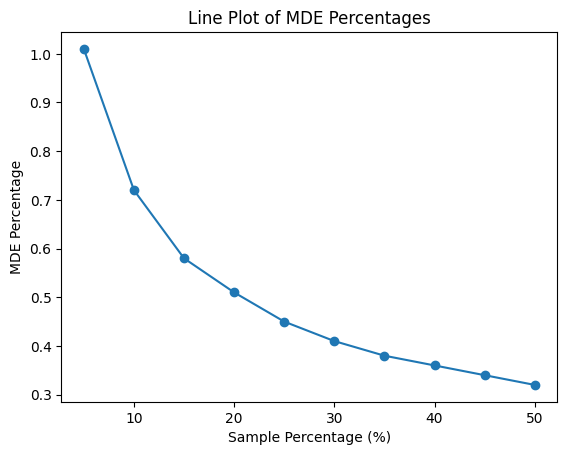

In [18]:
# Prepare data for plotting
percentage_split = [float(key)*100 for key in data.keys()]  # Convert keys to float and multiply by 100 to get percentages
mde_percentage_list_hist = [value['mde_%'] for value in data.values()]  # Extract MDE percentages

# Plotting
plt.plot(percentage_split, mde_percentage_list_hist, marker='o')  # 'o' adds markers to the line plot
plt.title('Line Plot of MDE Percentages')
plt.xlabel('Sample Percentage (%)')  # Updated to display counter percentage of the sample
plt.ylabel('MDE Percentage')

# Show the plot
plt.show()

In [9]:
# We run the split with 30% in test, as per the MDE curve we think it is the most optimal business<>statistical
test_df, control_df = train_test_split(df, test_size=0.3)

In [20]:
test_df

,price
695327,39
338242,60
635652,98
306032,6
42195,42
...,...
749893,24
659459,94
398127,71
351462,21


In [21]:
control_df

,price
459441,54
985835,68
458843,82
982058,83
682885,8
...,...
559471,24
260161,94
228127,67
651392,70


#### Conclusions and Key Insights:

1. MDE Decreases as Test Size Increases

MDE goes from 0.51 to 0.16 as the test size grows from 5% to 50%.
This makes sense because larger sample sizes increase statistical power, allowing detection of smaller effects.

2. MDE % Drops Sharply at First, Then Levels Off

The MDE% drops from 1.01% to 0.32%, but the biggest improvements come early:
* From 5% to 15%, MDE% drops from 1.01% to 0.59%
* From 25% to 50%, it only drops from 0.45% to 0.32%

**Diminishing returns:** increasing test size beyond ~30% yields smaller gains in sensitivity.

3. Average Price Remains Stable

The average control group price is very stable around 50.49, confirming that the random splits are balanced.



##### **Final Thoughts:**

**Tradeoff:** Smaller test sizes = less sensitive tests (higher MDE), but faster and cheaper.

If you're okay detecting only big effects, you can use smaller samples.
But if you want to detect subtle changes (e.g., a 0.3% lift), you'll need a larger test group.

### Performing the Kolmogorov-Smirnov Test

This step is here just to give some more insight on how A/B testing works. In a real use case scenario you don't care if the distributions look like they came from the same population, what you usually care about is the mean instead (which you check with the T-Test).


#### Selecting the Data

We begin by selecting the relevant data from each group. Specifically, we extract the `price` column from both the control and test DataFrames. These columns represent the variable of interest for our analysis, such as the outcome of a marketing strategy, product pricing impact, or any other metric crucial to our A/B test.

```python
data1 = control_df['price']  # Extracting price data from the control group
data2 = test_df['price']  # Extracting price data from the test group
```
**Conducting the Kolmogorov-Smirnov (KS) Test**

With our data selected, we proceed to conduct the Kolmogorov-Smirnov (KS) test. This non-parametric test assesses the hypothesis that the distributions of two samples are the same. It is particularly useful in A/B testing for comparing the outcome distributions from our control and test groups without making assumptions about the underlying data distribution.

The KS test provides two key pieces of information:

- The KS statistic: A measure of the distance between the empirical distribution functions of the two samples.
- The p-value: Indicates the probability of observing the data assuming the null hypothesis is true. A low p-value (typically < 0.05) suggests that we can reject the null hypothesis and conclude that the distributions of the two samples are significantly different.

```python
statistic, p_value = ks_2samp(data1, data2)
print(f"KS statistic: {statistic}")
print(f"P-value: {p_value}")
```
The outcome of the KS test helps us understand whether the interventions or changes we're testing have a statistically significant impact on the distribution of our metric of interest, allowing us to make informed decisions based on our A/B testing results.

In [82]:
# Selecting the data from each DataFrame
data1 = control_df['price']  # We select the column price from our df
data2 = test_df['price']  # We select the column price from our df

# Perform the KS test
statistic, p_value = ks_2samp(data1, data2)

print(f"KS statistic: {statistic}")
print(f"P-value: {p_value}")

KS statistic: 0.0015142857142857458
P-value: 0.7207084247789215


**Conclusion:** With a p-value above 0.05, we cannot reject the null hypothesis, meaning **we cannot conclude that the *test* group is significantly different from the *control* group**. As expected, since we randomly selected values from the same population/distribution.

## Performing a T-test

In this section, we perform a t-test between two datasets, `data1` and `data2`. A t-test is a statistical test that is used to compare the means of two groups. It helps us understand if the differences between the two sets are statistically significant. This is particularly useful in A/B testing, where one group is often a control group and the other is a treatment group.

The t-test has several assumptions:
- The samples are independently and randomly drawn.
- The distribution of the sample means is normal.
- The variances of the two groups are equal.

In [89]:
test_df, control_df = train_test_split(df, test_size=0.3, random_state=42)

# Perform the t-test
t_stat, p_value = ttest_ind(control_df, test_df)
# 0.3 -> 'mde': 0.20
# 0.5 -> 'mde': 0.16

# Print the results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("There is a significant difference between the two groups.")
else:
    print("There is no significant difference between the two groups.")

T-statistic: [1.07043486]
P-value: [0.28442387]
There is no significant difference between the two groups.


**Interpretation**
- **T-statistic**: This value helps us understand the size of the difference relative to the variation in our sample data. A larger t-statistic indicates a greater difference between the groups.
- **P-value**: This value tells us about the probability that we would see the observed difference (or more extreme) if there were no actual difference between the groups. A p-value less than 0.05 is typically considered to be statistically significant.

### Self Guided Research

#### Calculating Temporal Minimum Detectable Effect (MDE)

When designing A/B tests or any data-driven experiment, understanding the Minimum Detectable Effect (MDE) over time can be crucial. The MDE represents the smallest effect size that the test is adequately powered to identify. As data accumulates and distributions stabilize over time, the MDE can decrease. This means that effects which may not be detectable with a smaller dataset (e.g., weekly data) might become apparent when analyzing a larger dataset collected over a longer period (e.g., monthly or quarterly data).

**Understanding the Approach**

In a scenario where consumer behavior is tracked over time, such as purchasing habits for a specific product (e.g., detergent), it's common not to observe significant changes within short time frames like a week. However, over a month or more, purchasing patterns can emerge more clearly.

To accommodate this temporal aspect in our analysis, our dataset evolves to include multiple columns, each representing the cumulative average consumption over increasing time periods. For example:
- Column 1 might represent the average consumption for January.
- Column 2 could represent the cumulative average for January and February.
- Column 3 would then include the cumulative average for January, February, and March, and so on.

This structure allows us to observe how the average consumption stabilizes or changes as more data is accumulated over time.

**Reapplying the MDE Calculation**

With this temporal dataset structure, we can reapply our MDE calculation method. By iterating through the columns (each representing cumulative averages over different time periods), we perform the MDE calculation for each time slice. This iterative process is akin to the original approach where we calculated the MDE for different sample sizes. However, in this context, we're evaluating how the temporal extension of our data affects the MDE.

**Visualizing the Temporal MDE**

After recalculating the MDEs for each cumulative time period, we plot these values on a histogram. This visualization aids in selecting the optimal MDE and sample size (or, in this case, the time frame) for our experiment. The histogram will show us how the MDE decreases as the time frame widens, providing a clear picture of when our data becomes sufficiently robust to reliably detect the effects we're interested in.